In [ ]:
!pip install Bio
!pip install seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import Bio

# Gene Expression Data

### General data pre-processing

Data imports, Entrez parser, ID indexing

In [ ]:
# Import data
gene_exp = pd.read_csv("./G4/G4_liver_gene-expr.csv") #for local
# Rename patient column
gene_exp.rename(columns={'Unnamed: 0': 'Patient'}, inplace=True)

# Replace Entrez IDs with Gene Names using Entrez Parser from Bio
unknown_genes = [str(x.split('..')[1]) for x in list(gene_exp.columns) if x.startswith('X..')]
# Parser
import sys
from Bio import Entrez
Entrez.email = "rafaelrtubelleza@gmail.com"

def retrieve_annotation(id_list):
    request = Entrez.epost("gene", id=",".join(id_list))
    try:
        result = Entrez.read(request)
    except RuntimeError as e:
        print("An error occurred while retrieving the annotations.")
        print("The error returned was %s" % e)
        sys.exit(-1)
    webEnv = result["WebEnv"]
    queryKey = result["QueryKey"]
    data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
    annotations = Entrez.read(data)
    print("Retrieved %d annotations for %d genes" % (len(annotations), len(id_list)))
    return annotations

unknown_annotated = retrieve_annotation(unknown_genes)
#Mapper to convert columns
unknown_mapper = dict()
for hits in unknown_annotated['DocumentSummarySet']['DocumentSummary']:
    gene_id = 'X..'+(hits.attributes['uid'])
    gene_name = hits['Description']
    unknown_mapper[gene_id] = gene_name
gene_exp.rename(columns=unknown_mapper, inplace=True)

# Set patient IDs as index column
gene_exp.set_index('Patient', inplace=True)

Retrieved 1 annotations for 29 genes


### Filter genes with sparse expression across all samples

In [ ]:
# Filter out 'sparsely expressed' genes/columns
# Some genes have majority 0.0 = implies many imputed missing data. Remove these.
drop_list = []
for cols in gene_exp:
    zero_count = (gene_exp[cols] == 0).sum()
    if zero_count/len(gene_exp) >= 0.9: # If 90% or more of the data consists of 0, drop.
        drop_list.append(cols)
gene_exp.drop(drop_list, inplace=True, axis=1)

### Visualise raw RPKM distributions, for each gene

In [ ]:
# Describe by column/gene
ge_summary = gene_exp.describe()

,ubiquitin-conjugating enzyme E2Q family member 2 pseudogene 3,UBE2Q2 pseudogene 2,high mobility group box 1 pseudogene 1,translocase of inner mitochondrial membrane 23 homolog (yeast),AI894139 pseudogene,"RNA, U12 small nuclear 2, pseudogene","SSX family member 9, pseudogene",EZH inhibitory protein,EF-hand calcium binding domain 8,signal recognition particle 14 pseudogene 1,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,...,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,4.426418,4.593710,94.809400,1165.641678,166.341208,0.229541,1.622433,9.220335,1.184421,4.730180,...,30.690598,634.716146,972.982056,44.870022,1005.656232,3798.039789,699.259471,575.195675,8.625873,94.010640
std,4.980456,4.288338,37.810548,362.082058,164.753650,0.479947,5.580559,91.842992,2.315644,2.952265,...,15.848531,461.419979,265.285781,51.464815,506.806796,2087.375699,310.427234,226.161558,26.068837,96.880423
min,0.000000,0.000000,22.245600,372.859500,6.106900,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,19.459500,216.681800,0.000000,84.315500,299.822900,167.392000,163.893500,0.000000,0.000000
25%,1.182000,1.666700,68.359100,913.894300,57.971000,0.000000,0.000000,0.000000,0.000000,2.579500,...,19.842600,332.370500,790.497400,8.222900,625.879000,2339.744900,477.031800,423.860200,1.726400,11.313100
50%,3.112700,3.526300,88.379000,1127.637100,118.421100,0.000000,0.000000,0.000000,0.608300,4.331300,...,29.086800,522.444600,941.280800,29.622700,894.285700,3534.646200,616.786300,542.439000,3.533600,76.587700
75%,6.358800,6.312100,115.889500,1361.779700,208.821200,0.466600,0.000000,0.608300,1.512900,6.340100,...,39.769500,808.783800,1124.617700,60.189200,1280.064100,4761.133600,860.793500,696.766800,7.387400,138.435100
max,45.183600,31.037000,257.324800,2970.130400,1258.155300,5.356500,60.416900,1833.905300,32.581700,18.782000,...,129.124000,4482.958200,2063.614300,405.928600,2812.612600,15604.016000,1822.845700,2093.944200,350.352100,693.032000


#### Raw RPKM

[Text(0.5, 0, 'Median RPKM')]

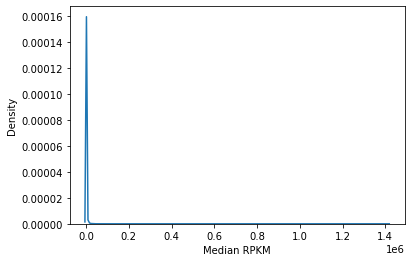

In [ ]:
# Visualise distributions of means
# No log
#sns.kdeplot(ge_summary.loc['mean']).set(xlabel='Median RPKM')
sns.kdeplot(ge_summary.loc['50%']).set(xlabel='Median RPKM')

# Each data point is the mean RPKM of each gene, averaged across all samples
# From this plot, you can see that it is highly skewed,
# Therefore some genes have generally much higher raw RPKM values (on average, for all samples).

#### Log2(RPKM)

In [ ]:
# Take the log2 transformation of RPKM values, for each patient
# For each patient, we want to scale the expression of each gene by log2 - punish/scale down very large raw RPKM values
# To prevent masking of smaller raw RPKM values

gene_exp_log2 = gene_exp.copy()
label = gene_exp_log2['Label']
gene_exp_log2.drop('Label', axis=1, inplace=True)
gene_exp_log2 = np.log2(gene_exp_log2 + 1) # with pseudocount
gene_exp_log2.insert(0, 'Label', label)

In [ ]:
gel_summary = gene_exp_log2.describe()

[Text(0.5, 0, 'Median $Log_{2}$ (RPKM)')]

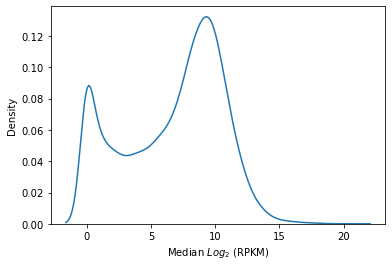

In [ ]:
# Visualise distributions of means
# No log
#sns.kdeplot(gel_summary.loc['mean']).set(xlabel='Mean $Log_{2}$ (RPKM)')
sns.kdeplot(gel_summary.loc['50%']).set(xlabel='Median $Log_{2}$ (RPKM)')

# From the means, this implies that there are some distributions of Log2(RPMK) clustered around low Log2 values of 0-3
# and some distributions around higher log2 values of 8

# Regardless, this scales the data somewhat more appropriately, where very small and very large RPKM values
# can be represented in the dataset, in comparison to dealing with a highly skewed dataset.

#### Min-Maxed Log2(RPKM)

In [ ]:
# Normalise by gene/column
# Min-Max scaling
# gene_exp_log2
gene_exp_norm_col_log2 = gene_exp_log2.copy()
for cols in gene_exp_norm_col_log2.columns:
    if cols != 'Label':
        col_max = gene_exp_norm_col_log2[cols].max()
        col_min = gene_exp_norm_col_log2[cols].min()
        if col_max == 0:
            gene_exp_nogene_exp_norm_col_log2rm_col.drop(cols, axis=1)
        else:
            gene_exp_norm_col_log2[cols] = (gene_exp_norm_col_log2[cols] - col_min)/(col_max - col_min) #norm each col.

In [ ]:
#sns.kdeplot
fin_summary = gene_exp_norm_col_log2.describe()

[Text(0.5, 0, 'Median Min-maxed $Log_{2}$ (RPKM)')]

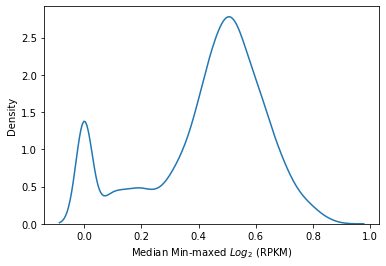

In [ ]:
#sns.kdeplot(fin_summary.loc['mean']).set(xlabel='Mean Min-maxed $Log_{2}$ (RPKM)')
sns.kdeplot(fin_summary.loc['50%']).set(xlabel='Median Min-maxed $Log_{2}$ (RPKM)')

#### Heatmap of Minmaxed Log2(RPKM)

/var/folders/0_/k8yl70wd2wz2n9x4ytr7_fw80000gn/T/ipykernel_42684/2349048167.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_exp_norm_col_log2['Label_col'] = gene_exp_norm_col_log2['Label'].map({'Solid Tissue Normal': 'b', 'Primary Tumor':'r'})


<Figure size 864x720 with 0 Axes>

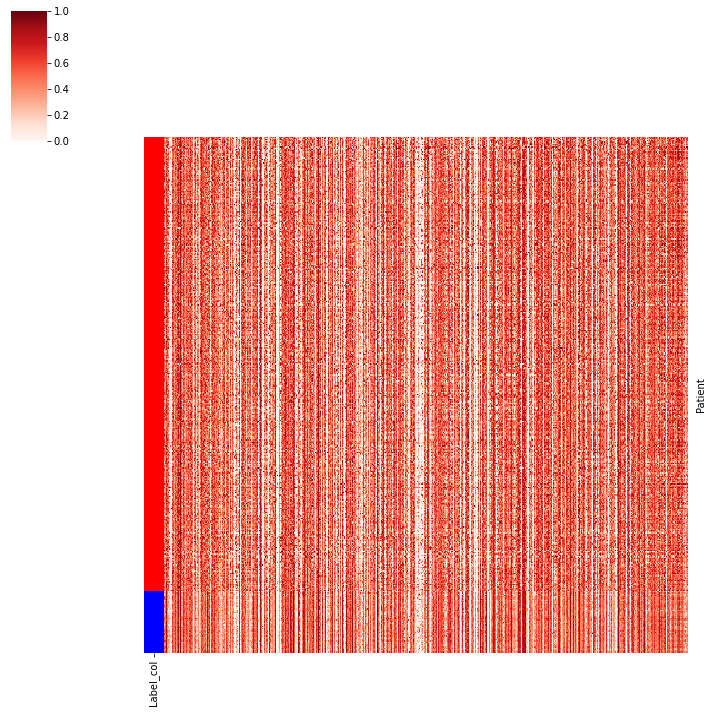

In [ ]:
# Heatmap
#from matplotlib.colors import LogNorm
# Sort by label
gene_exp_norm_col_log2.sort_values('Label', inplace=True, ascending=True)
# Row color mapping
gene_exp_norm_col_log2['Label_col'] = gene_exp_norm_col_log2['Label'].map({'Solid Tissue Normal': 'b', 'Primary Tumor':'r'})

plt.figure(figsize=(12,10))
raw_map = sns.clustermap(
    gene_exp_norm_col_log2.drop(['Label','Label_col'],axis=1,inplace=False),
    xticklabels=False,
    yticklabels=False,
    cmap='Reds',
    row_colors=gene_exp_norm_col_log2['Label_col'],
    row_cluster=False,
    col_cluster=False,
    )

# Feature Extraction by Exploratory Data Analysis

In [ ]:
# Min-Maxed Log2 RPKM. Do by median.
gene_exp_norm_col_log2_bylabel = gene_exp_norm_col_log2.groupby('Label').median()
gene_exp_norm_col_log2_bylabel.loc['FC'] = (gene_exp_norm_col_log2_bylabel.loc['Primary Tumor']/gene_exp_norm_col_log2_bylabel.loc['Solid Tissue Normal'])

In [ ]:
gene_exp_norm_col_log2_bylabel.loc['log2FC'] = np.log2(gene_exp_norm_col_log2_bylabel.loc['FC'] + 1)
log2FC_logminmax_dir = gene_exp_norm_col_log2_bylabel.loc['log2FC'].sort_values(ascending=False)
log2FC_logminmax_dir = log2FC_logminmax_dir[~(log2FC_logminmax_dir == np.inf)] # remove inf
log2FC_logminmax_dir = log2FC_logminmax_dir[~(log2FC_logminmax_dir.isna())] # remove nan
log2FC_logminmax_dir.sort_values(ascending=False)

MKRN3.7681         3.482984
RDM1.201299        3.443407
PXDNL.137902       3.385213
ZIC2.7546          3.230975
HHIPL2.79802       3.079632
                     ...   
C10orf90.118611    0.000000
C9orf71.169693     0.000000
CLRN1OS.116933     0.000000
DMRTC1B.728656     0.000000
CLDN8.9073         0.000000
Name: log2FC, Length: 16693, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'MKRN3.7681'),
  Text(1, 0, 'RDM1.201299'),
  Text(2, 0, 'PXDNL.137902'),
  Text(3, 0, 'ZIC2.7546'),
  Text(4, 0, 'HHIPL2.79802')])

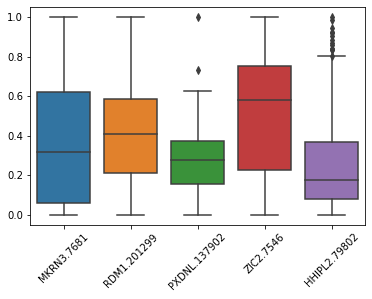

In [ ]:
## Choose based on Log2minmax data. As a test, get the top 5.
selected_genes = list(log2FC_logminmax_dir[:5].index)
selected_genes.insert(0, 'Label')
gene_exp_norm_col_log2[selected_genes]
sns.boxplot(gene_exp_norm_col_log2[selected_genes])
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'LIN28B.389421'),
  Text(1, 0, 'DCAF8L2.347442'),
  Text(2, 0, 'NAA11.84779'),
  Text(3, 0, 'TMPRSS15.5651'),
  Text(4, 0, 'DSCR4.10281')])

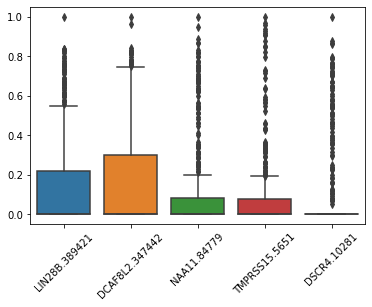

In [ ]:
# but what if we did the mean:
# Min-Maxed Log2 RPKM. Do by mean.
gene_exp_norm_col_log2_bylabel = gene_exp_norm_col_log2.groupby('Label').mean()
gene_exp_norm_col_log2_bylabel.loc['FC'] = (gene_exp_norm_col_log2_bylabel.loc['Primary Tumor']/gene_exp_norm_col_log2_bylabel.loc['Solid Tissue Normal'])
gene_exp_norm_col_log2_bylabel.loc['log2FC'] = np.log2(gene_exp_norm_col_log2_bylabel.loc['FC'] + 1)
log2FC_logminmax_dir = gene_exp_norm_col_log2_bylabel.loc['log2FC'].sort_values(ascending=False)
log2FC_logminmax_dir = log2FC_logminmax_dir[~(log2FC_logminmax_dir == np.inf)] # remove inf
log2FC_logminmax_dir = log2FC_logminmax_dir[~(log2FC_logminmax_dir.isna())] # remove nan
log2FC_logminmax_dir.sort_values(ascending=False)
selected_genes = list(log2FC_logminmax_dir[:5].index)
selected_genes.insert(0, 'Label')
gene_exp_norm_col_log2[selected_genes]
sns.boxplot(gene_exp_norm_col_log2[selected_genes])
plt.xticks(rotation=45)

In [ ]:
# Highly skewed
# Rerun cell to convert back to median version
gene_exp_norm_col_log2_bylabel = gene_exp_norm_col_log2.groupby('Label').median()
gene_exp_norm_col_log2_bylabel.loc['FC'] = (gene_exp_norm_col_log2_bylabel.loc['Primary Tumor']/gene_exp_norm_col_log2_bylabel.loc['Solid Tissue Normal'])
gene_exp_norm_col_log2_bylabel.loc['log2FC'] = np.log2(gene_exp_norm_col_log2_bylabel.loc['FC'] + 1)
log2FC_logminmax_dir = gene_exp_norm_col_log2_bylabel.loc['log2FC'].sort_values(ascending=False)
log2FC_logminmax_dir = log2FC_logminmax_dir[~(log2FC_logminmax_dir == np.inf)] # remove inf
log2FC_logminmax_dir = log2FC_logminmax_dir[~(log2FC_logminmax_dir.isna())] # remove nan
log2FC_logminmax_dir.sort_values(ascending=False)

MKRN3.7681         3.482984
RDM1.201299        3.443407
PXDNL.137902       3.385213
ZIC2.7546          3.230975
HHIPL2.79802       3.079632
                     ...   
C10orf90.118611    0.000000
C9orf71.169693     0.000000
CLRN1OS.116933     0.000000
DMRTC1B.728656     0.000000
CLDN8.9073         0.000000
Name: log2FC, Length: 16693, dtype: float64

<AxesSubplot:ylabel='Label'>

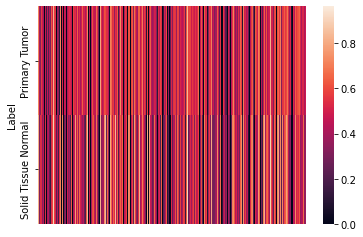

In [ ]:
sns.heatmap(gene_exp_norm_col_log2_bylabel.loc[['Primary Tumor', 'Solid Tissue Normal']], xticklabels=False)

In [ ]:
log2FC_logminmax = gene_exp_norm_col_log2_bylabel.loc['log2FC'].sort_values(ascending=False)
log2FC_logminmax = log2FC_logminmax[~(log2FC_logminmax == np.inf)]

# DNA-methylation Data

### Data Preprocessing

In [ ]:
# Import data
dna_meth = pd.read_csv("./G4/G4_liver_dna-meth.csv") #for local
# Rename patient column
dna_meth.rename(columns={'Unnamed: 0': 'Patient'}, inplace=True)
# Set patient column as index column
dna_meth.set_index('Patient', inplace=True)

In [ ]:
dna_meth.isnull().values.any()

False

#### Heatmap on raw

<Figure size 864x720 with 0 Axes>

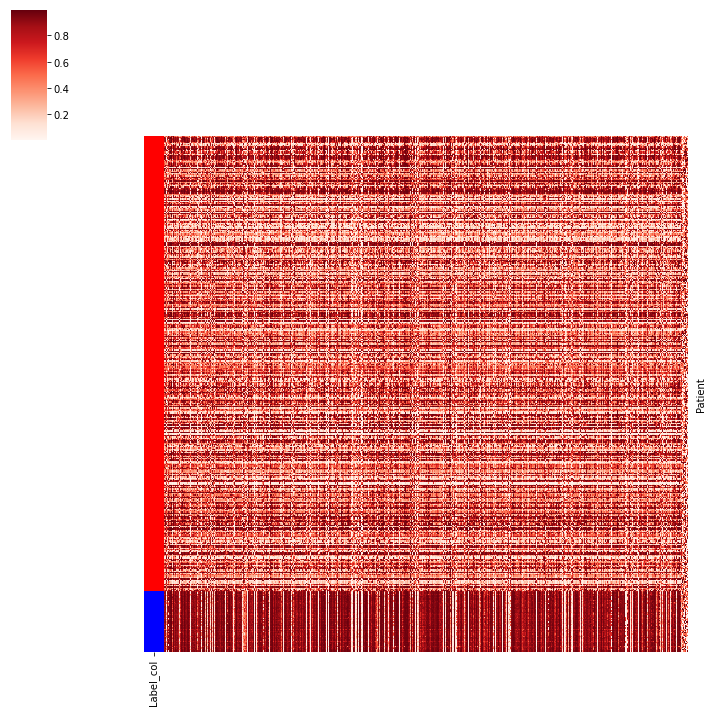

In [ ]:
dna_meth.sort_values('Label', inplace=True)

dna_meth['Label_col'] = dna_meth['Label'].map({'Solid Tissue Normal': 'b', 'Primary Tumor':'r'})
# Heatmap
#from matplotlib.colors import LogNorm
plt.figure(figsize=(12,10))
raw_map = sns.clustermap(
    dna_meth.drop(['Label','Label_col'],axis=1,inplace=False),
    xticklabels=False,
    yticklabels=False,
    cmap='Reds',
    row_colors=dna_meth['Label_col'],
    row_cluster=False,
    col_cluster=False,
    )

In [ ]:
dnamethdesc = dna_meth.describe()
dnamethdesc

,cg00005740,cg00012529,cg00013196,cg00019366,cg00028598,cg00030627,cg00033551,cg00047815,cg00049102,cg00049709,...,rs7660805,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,...,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,0.582281,0.639985,0.561627,0.550916,0.548317,0.601201,0.724739,0.620792,0.629298,0.548121,...,0.591112,0.577177,0.545631,0.444666,0.385080,0.514060,0.642696,0.562312,0.447876,0.421236
std,0.310583,0.303628,0.309317,0.295205,0.343076,0.293078,0.310305,0.289005,0.291637,0.286677,...,0.330201,0.346058,0.434180,0.328879,0.336497,0.353697,0.321497,0.352195,0.322072,0.311345
min,0.039608,0.062012,0.053980,0.044230,0.023959,0.062076,0.025082,0.056208,0.054950,0.051349,...,0.025750,0.017123,0.010862,0.029935,0.011137,0.015861,0.019565,0.017741,0.027191,0.023094
25%,0.288952,0.361260,0.263254,0.281999,0.225844,0.324903,0.423453,0.360460,0.358055,0.275104,...,0.462075,0.440037,0.018502,0.068978,0.019419,0.036669,0.519087,0.406903,0.048260,0.046926
50%,0.635024,0.666056,0.511991,0.545151,0.508285,0.626756,0.937383,0.666963,0.695542,0.508115,...,0.561440,0.495198,0.484135,0.451876,0.495572,0.506229,0.615203,0.544963,0.514316,0.473344
75%,0.887110,0.965430,0.913352,0.860621,0.932278,0.906213,0.968806,0.912158,0.916127,0.847222,...,0.940695,0.958705,0.968286,0.798574,0.549994,0.956595,0.936819,0.956633,0.549982,0.541053
max,0.976405,0.985192,0.959916,0.957345,0.981789,0.960817,0.986276,0.964061,0.964045,0.962180,...,0.975499,0.973883,0.980037,0.960921,0.975837,0.977459,0.964556,0.977682,0.978362,0.963037


In [ ]:
# Mins around 0, Maxes around 1

In [ ]:
# Smallest minimum is 0.007
dnamethdesc.loc['min'].min()

0.0079563614394841

In [ ]:
# Biggest maximum is 0.993
dnamethdesc.loc['max'].max()

0.993645538784571

In [ ]:
# Raw beta values lie 0 to 1. looks good. No need for normalisation.

# Feature Extraction

In [ ]:
dm_summary = dna_meth.describe()

Text(0.5, 0, 'Mean beta value')

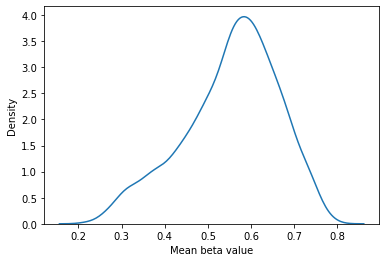

In [ ]:
sns.kdeplot(dm_summary.loc['mean']).set_xlabel('Mean beta value')

In [ ]:
# Good. indicates no masking, or overrpresentation of probes. Can just use mean.

In [ ]:
# ByLabel. Mean
dna_meth_bylabel = dna_meth.groupby('Label').mean()
dna_meth_bylabel.loc['FC'] = (dna_meth_bylabel.loc['Primary Tumor']/dna_meth_bylabel.loc['Solid Tissue Normal'])
dna_meth_bylabel.loc['log2FC'] = np.log2(dna_meth_bylabel.loc['FC'] + 1)

In [ ]:
dna_meth_bylabel.loc['log2FC'].sort_values(ascending=False)

cg15044248    4.553171
cg05327835    4.359379
cg11376305    4.339209
cg16779463    4.159826
cg04907523    3.990337
                ...   
cg24833737    0.425402
cg25225379    0.424071
cg14715697    0.420244
cg18837292    0.405819
cg12680131    0.396438
Name: log2FC, Length: 5000, dtype: float64

<AxesSubplot:>

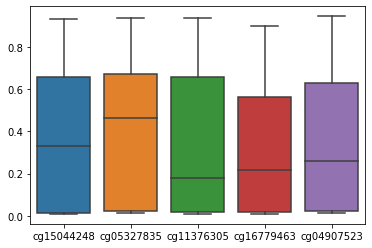

In [ ]:
top5_probes = list(dna_meth_bylabel.loc['log2FC'].sort_values(ascending=False)[:5].index)
selected_probes = top5_probes
selected_probes.insert(0, 'Label')
sns.boxplot(dna_meth[selected_probes])

In [ ]:
# Distributions good too. No need to change selection metric from mean.

# Data Extraction for ML

In [ ]:
# Want to iterate over top X probes/genes.
# Use loop.

In [ ]:
# 1 to 10
for n in range(1,11):
    probes = list(dna_meth_bylabel.loc['log2FC'].sort_values(ascending=False)[:n].index)
    genes = list(log2FC_logminmax_dir[:n].index)
    # genes = list(log2FC_logminmax_dir[:5].index)
    probes.insert(0, 'Label')
    genes.insert(0, 'Label')
    dna_meth[probes].to_csv(f'dna_meth_{n}probes.csv')
    gene_exp_norm_col_log2[genes].to_csv(f'gene_exp_norm_col_log2_{n}genes.csv')

In [ ]:
# 15, 20, 50

for n in [15, 20, 50]:
    probes = list(dna_meth_bylabel.loc['log2FC'].sort_values(ascending=False)[:n].index)
    genes = list(log2FC_logminmax[:n].index)
    # genes = list(log2FC_logminmax_dir[:5].index)
    probes.insert(0, 'Label')
    genes.insert(0, 'Label')
    dna_meth[probes].to_csv(f'dna_meth_{n}probes.csv')
    gene_exp_norm_col_log2[genes].to_csv(f'gene_exp_norm_col_log2_{n}genes.csv')